In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from collections import Counter
from random import randint, uniform


from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

from fuzzywuzzy import process

/opt/anaconda3/envs/dl/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Loading Dataset

In [5]:
products = pd.read_csv('Amazon-Products.csv')
products.head(5)

,Unnamed: 0,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
0,0,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/31UISB90sY...,https://www.amazon.in/Lloyd-Inverter-Convertib...,4.2,"2,255","₹32,999","₹58,990"
1,1,LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Convertible-Anti-Viru...,4.2,"2,948","₹46,490","₹75,990"
2,2,LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Cop...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Inverter-Convertible-...,4.2,"1,206","₹34,490","₹61,990"
3,3,LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Convertible-Anti-Viru...,4.0,69,"₹37,990","₹68,990"
4,4,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/41lrtqXPiW...,https://www.amazon.in/Carrier-Inverter-Split-C...,4.1,630,"₹34,490","₹67,790"


In [6]:
products.shape

(551585, 10)

In [7]:
# Removing uncessary columns -> (Unnamed: 0, image, link)
products.drop(columns=['Unnamed: 0', 'image', 'link'], inplace=True)



In [8]:
# Total null values
print(f"Total null value in product table:\n{products.isnull().sum()}")

Total null value in product table:
name                   0
main_category          0
sub_category           0
ratings           175794
no_of_ratings     175794
discount_price     61163
actual_price       17813
dtype: int64


In [9]:
products.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551585 entries, 0 to 551584
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            551585 non-null  object
 1   main_category   551585 non-null  object
 2   sub_category    551585 non-null  object
 3   ratings         375791 non-null  object
 4   no_of_ratings   375791 non-null  object
 5   discount_price  490422 non-null  object
 6   actual_price    533772 non-null  object
dtypes: object(7)
memory usage: 29.5+ MB


In [10]:
products['main_category'].value_counts()

main_category
accessories                116141
men's clothing              76656
women's clothing            76512
tv, audio & cameras         68659
men's shoes                 57456
appliances                  33096
stores                      32903
home & kitchen              14568
kids' fashion               13488
sports & fitness            12648
bags & luggage              10416
beauty & health             10122
car & motorbike              7080
toys & baby products         6216
women's shoes                5472
industrial supplies          4104
grocery & gourmet foods      3312
pet supplies                 1632
music                        1080
home, kitchen, pets            24
Name: count, dtype: int64

In [11]:
products = products.groupby('main_category').apply(lambda x:x.head(2500))

In [12]:
products.reset_index(drop=True, inplace=True)
products.shape

(45236, 7)

### Data Pre-Processing

In [13]:
# unique values of ratings column
print(f"Unique values of ratings:\n{products['ratings'].unique()}")
# unique values of no_of_ratings column
print(f"Unique values of no_of_ratings:\n{products['no_of_ratings'].unique()}")



Unique values of ratings:
['3.9' '4.5' '4.3' '4.4' '4.1' '4.0' '4.2' '4.7' '3.7' '3.5' '3.8' '4.6'
 '4.9' '2.9' '3.2' '3.6' '4.8' '3.4' '3.3' '5.0' nan '3.0' '1.0' '2.4'
 '3.1' '2.8' '2.5' '2.7' '2.6' 'FREE' '2.3' '1.7' 'Get' '1.8' '2.2' '1.6'
 '1.9' '2.0' '1.4' '1.5' '2.1' '1.3' '1.2' '₹68.99']
Unique values of no_of_ratings:
['18,662' '453' '15,905' ... '8,483' 'Usually dispatched in 3 to 4 weeks.'
 '4,605']


In [14]:
products['no_of_ratings'] = products['no_of_ratings'].str.replace(",","")
products['no_of_ratings'] = pd.to_numeric(products['no_of_ratings'], errors="coerce", downcast="integer")

In [15]:
products = products.replace({
    'ratings': {r'₹\w+[.]\w+':'3.0', r'FREE':'3.0', r'Get':'3.0', r'₹\w+':'3.0'},
}, regex=True)

In [16]:
print(f"Updated values of ratings:\n{products['ratings'].unique()}")

Updated values of ratings:
['3.9' '4.5' '4.3' '4.4' '4.1' '4.0' '4.2' '4.7' '3.7' '3.5' '3.8' '4.6'
 '4.9' '2.9' '3.2' '3.6' '4.8' '3.4' '3.3' '5.0' nan '3.0' '1.0' '2.4'
 '3.1' '2.8' '2.5' '2.7' '2.6' '2.3' '1.7' '1.8' '2.2' '1.6' '1.9' '2.0'
 '1.4' '1.5' '2.1' '1.3' '1.2']


In [17]:
products['ratings'] = pd.to_numeric(products['ratings'], errors='coerce', downcast='integer')

In [18]:
# Handling Null values
products['ratings'].fillna(round(products['ratings'].mean(),1), inplace=True)
products['no_of_ratings'].fillna(round(products['no_of_ratings'].mean()), inplace=True)

In [19]:
products['actual_price'] = pd.to_numeric(products['actual_price'].str.replace("₹","").str.replace(",",""), errors='coerce', downcast='integer')
products['discount_price'] = pd.to_numeric(products['discount_price'].str.replace("₹","").str.replace(",",""), errors='coerce', downcast='integer')

In [20]:
print(f"Total null values in actual price column: {products['actual_price'].isnull().sum()}")
print(f"Total null values in discount price column: {products['discount_price'].isnull().sum()}")

Total null values in actual price column: 883
Total null values in discount price column: 4818


In [21]:
print(f"Mean of actual price column: {round(products['actual_price'].mean())}")
print(f"Mean of discount price column: {round(products['discount_price'].mean())}")

Mean of actual price column: 2941
Mean of discount price column: 1729


In [22]:
# Filling the null values based on sub category
# grouping the rows by sub category,  find the mean -> replace the NULL values

mean_actual_price_by_sub_category = round(products.groupby('sub_category')[['actual_price','discount_price']].mean()).reset_index()
mean_actual_price_by_sub_category


,sub_category,actual_price,discount_price
0,Air Conditioners,54815.0,40756.0
1,All Appliances,7017.0,4532.0
2,All Car & Motorbike Products,1603.0,889.0
3,All Electronics,5419.0,3086.0
4,All Exercise & Fitness,2156.0,979.0
5,All Grocery & Gourmet Foods,511.0,387.0
6,All Home & Kitchen,2238.0,1275.0
7,All Pet Supplies,1058.0,670.0
8,"All Sports, Fitness & Outdoors",2381.0,1207.0
9,Amazon Fashion,1939.0,906.0


In [23]:
mean_actual_price_dict = mean_actual_price_by_sub_category.set_index('sub_category')['actual_price'].to_dict()
mean_discount_price_dict = mean_actual_price_by_sub_category.set_index('sub_category')['discount_price'].to_dict()

In [24]:
mean_actual_price_dict

{'Air Conditioners': 54815.0,
 'All Appliances': 7017.0,
 'All Car & Motorbike Products': 1603.0,
 'All Electronics': 5419.0,
 'All Exercise & Fitness': 2156.0,
 'All Grocery & Gourmet Foods': 511.0,
 'All Home & Kitchen': 2238.0,
 'All Pet Supplies': 1058.0,
 'All Sports, Fitness & Outdoors': 2381.0,
 'Amazon Fashion': 1939.0,
 'Baby Bath, Skin & Grooming': 1046.0,
 'Baby Fashion': 1286.0,
 'Baby Products': 1188.0,
 'Backpacks': 3490.0,
 'Badminton': 2591.0,
 'Bags & Luggage': 2486.0,
 'Ballerinas': 3108.0,
 'Beauty & Grooming': 740.0,
 'Bedroom Linen': 1885.0,
 'Car & Bike Care': 2023.0,
 'Car Accessories': 1488.0,
 'Casual Shoes': 3017.0,
 'Clothing': 1727.0,
 'Coffee, Tea & Beverages': 640.0,
 'Diapers': 1333.0,
 'Diet & Nutrition': 1245.0,
 'Dog supplies': 1207.0,
 'Fashion Sales & Deals': 3983.0,
 'Fashion Sandals': 1712.0,
 'Furniture': 3420.0,
 'Industrial & Scientific Supplies': 1611.0,
 'Innerwear': 766.0,
 'Janitorial & Sanitation Supplies': 1497.0,
 "Kids' Clothing": 1455.0

In [25]:
products['actual_price'] = products.apply(lambda x: x['actual_price'] if pd.notna(x['actual_price']) else mean_actual_price_dict.get(x['sub_category']), axis=1)
products['discount_price'] = products.apply(lambda x: x['discount_price'] if pd.notna(x['discount_price']) else mean_discount_price_dict.get(x['sub_category']), axis=1)

In [26]:
products.isnull().sum()

name              0
main_category     0
sub_category      0
ratings           0
no_of_ratings     0
discount_price    0
actual_price      0
dtype: int64

##### Distribution of Products Ratings

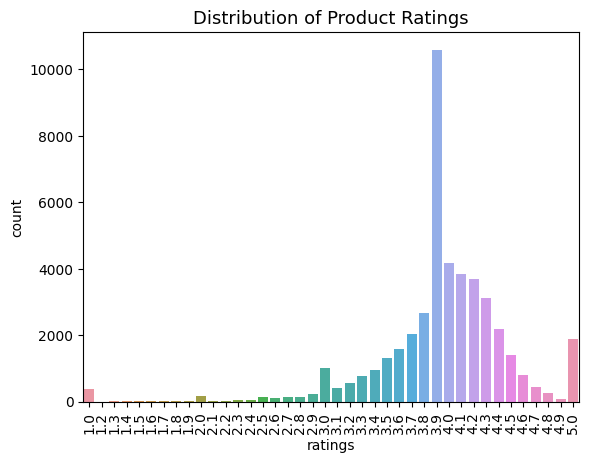

In [27]:
sns.countplot(x='ratings', data=products)
plt.title('Distribution of Product Ratings', fontsize=13)
plt.xticks(rotation=90)
plt.show()

In [28]:
products['name'].value_counts().head(20)

name
Backpack For Women's/Girls                                                                                                       93
Generic Polyster Light Weight Laptop Bag / Laptop Backpack for Upto 15.6 inch Laptop                                             48
Style Buy Style Women's Synthetic Casual & Party Bellies | Women's Ballet Flat                                                   30
crocs Unisex-Adult Bayaband Clog Lemon/White Clog - 8 UK Men/ 9 UK Women (M9W11) (205089-7B0)                                    26
Peter England Men Trunks                                                                                                         22
ARVESA Monthly Birthday Milestone Special Unisex Baby Romper Onesies Dress Half Sleeve Envelope Neck                             21
KAYU™ Boys Cotton Solid Regular Fit Capri 3/4th Pants {Pack of 5}                                                                19
KAYU™ Boys Cotton Solid Regular Fit Capri 3/4th Pants {Pack of 4}      

In [29]:
products = products.drop_duplicates()

In [30]:
products

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price
0,GLUN Bolt Electronic Portable Fishing Hook Typ...,accessories,Bags & Luggage,3.9,18662.0,278.0,899.0
1,Boldfit Shoe Bag for Travel & Storage Travel O...,accessories,Bags & Luggage,4.5,453.0,199.0,599.0
2,Storite 2 Pack Moisture Proof Nylon Large Size...,accessories,Bags & Luggage,4.3,15905.0,699.0,1999.0
3,GoTrippin Metal Luggage Weighing Scale Digital...,accessories,Bags & Luggage,4.4,8614.0,699.0,1200.0
4,"Safari Pentagon Trolley Bags for Travel, 55 cm...",accessories,Bags & Luggage,4.1,1522.0,1999.0,7775.0
...,...,...,...,...,...,...,...
45231,Metro Women Beaded Sandals (35-3787),women's shoes,Fashion Sandals,3.2,13.0,1145.0,2290.0
45232,Sharon by Khadim's Women Grey Heel Sandal,women's shoes,Fashion Sandals,3.1,9.0,853.0,1199.0
45233,Denill Women And Girls Ankle Strap Fashion San...,women's shoes,Fashion Sandals,3.1,48.0,249.0,1499.0
45234,RESTAYEL Woman Trending Stylish Fancy and Comf...,women's shoes,Fashion Sandals,3.6,16.0,299.0,999.0


In [31]:
products['productId'] = pd.factorize(products['name'])[0] + 1

In [32]:
print(f"Unique Count of product name: {products['name'].nunique()}")
print(f"Unique Count of product Id: {products['productId'].nunique()}")

Unique Count of product name: 41200
Unique Count of product Id: 41200


In [33]:
# Random generation of number to product userId
products['random_number_userId'] = [randint(5,20) for i in products.index]

In [34]:
updated_products = products.loc[products.index.repeat(products['random_number_userId'])]
updated_products['userId'] = updated_products.groupby(level=0).cumcount()+1

In [35]:
updated_products = updated_products.reset_index(drop=True)

In [36]:
updated_products.shape

(549237, 10)

In [37]:
updated_products.head(5)

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price,productId,random_number_userId,userId
0,GLUN Bolt Electronic Portable Fishing Hook Typ...,accessories,Bags & Luggage,3.9,18662.0,278.0,899.0,1,19,1
1,GLUN Bolt Electronic Portable Fishing Hook Typ...,accessories,Bags & Luggage,3.9,18662.0,278.0,899.0,1,19,2
2,GLUN Bolt Electronic Portable Fishing Hook Typ...,accessories,Bags & Luggage,3.9,18662.0,278.0,899.0,1,19,3
3,GLUN Bolt Electronic Portable Fishing Hook Typ...,accessories,Bags & Luggage,3.9,18662.0,278.0,899.0,1,19,4
4,GLUN Bolt Electronic Portable Fishing Hook Typ...,accessories,Bags & Luggage,3.9,18662.0,278.0,899.0,1,19,5


In [38]:
## Updaing user ratings (randomly between 1.0 - 5.0)
updated_products['ratings'] = [round(uniform(1,5),1) for i in updated_products.index]

#### Bayesian Average

In [39]:
products_stats = updated_products.groupby('productId')['ratings'].agg(['count','mean'])
products_stats

,count,mean
productId,,
1,36,2.875000
2,22,3.427273
3,10,2.960000
4,10,3.270000
5,15,3.033333
...,...,...
41196,13,3.823077
41197,11,3.627273
41198,5,3.820000


In [40]:
c = products_stats['count'].mean()
m = products_stats['mean'].mean()

In [41]:
def bayesain_average(ratings):
    bayesain_avg = (c*m+ratings.sum())/(c+ratings.count())
    return round(bayesain_avg, 3)

In [42]:
test = pd.Series([4.9])
bayesain_average(test)

3.134

#### Applying bayesain average on dataset

In [43]:
updated_products.head(5)

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price,productId,random_number_userId,userId
0,GLUN Bolt Electronic Portable Fishing Hook Typ...,accessories,Bags & Luggage,4.9,18662.0,278.0,899.0,1,19,1
1,GLUN Bolt Electronic Portable Fishing Hook Typ...,accessories,Bags & Luggage,5.0,18662.0,278.0,899.0,1,19,2
2,GLUN Bolt Electronic Portable Fishing Hook Typ...,accessories,Bags & Luggage,1.5,18662.0,278.0,899.0,1,19,3
3,GLUN Bolt Electronic Portable Fishing Hook Typ...,accessories,Bags & Luggage,1.8,18662.0,278.0,899.0,1,19,4
4,GLUN Bolt Electronic Portable Fishing Hook Typ...,accessories,Bags & Luggage,1.8,18662.0,278.0,899.0,1,19,5


In [44]:
bayesain_avg_ratings = updated_products.groupby('productId')['ratings'].agg(bayesain_average).reset_index()
bayesain_avg_ratings.columns = ["productId","bayesain_avg_ratings"]
bayesain_avg_ratings.head(5)

,productId,bayesain_avg_ratings
0,1,2.909
1,2,3.267
2,3,2.984
3,4,3.117
4,5,3.018


In [45]:
products_stats = products_stats.merge(bayesain_avg_ratings, on='productId')
products_stats.head()

,productId,count,mean,bayesain_avg_ratings
0,1,36,2.875000,2.909
1,2,22,3.427273,3.267
2,3,10,2.960000,2.984
3,4,10,3.270000,3.117
4,5,15,3.033333,3.018


In [46]:
products_stats = products_stats.merge(updated_products[['productId','name']])
products_stats.sort_values('bayesain_avg_ratings', ascending=False).head()

,productId,count,mean,bayesain_avg_ratings,name
344139,25445,9,4.477778,3.596,Duke Men Loafers
344138,25445,9,4.477778,3.596,Duke Men Loafers
344137,25445,9,4.477778,3.596,Duke Men Loafers
344136,25445,9,4.477778,3.596,Duke Men Loafers
344135,25445,9,4.477778,3.596,Duke Men Loafers


In [47]:
products_stats.sort_values('bayesain_avg_ratings', ascending=True).head()

,productId,count,mean,bayesain_avg_ratings,name
204481,15096,20,2.06,2.437,"AGARO Borosilicate Glass Containers with Lids,..."
204482,15096,20,2.06,2.437,"AGARO Borosilicate Glass Containers with Lids,..."
204483,15096,20,2.06,2.437,"AGARO Borosilicate Glass Containers with Lids,..."
204484,15096,20,2.06,2.437,"AGARO Borosilicate Glass Containers with Lids,..."
204485,15096,20,2.06,2.437,"AGARO Borosilicate Glass Containers with Lids,..."


#### Utility Matrix

In [48]:
def utility_matrix(df):
    
    """
        user_mapper: maps user id to user index
        product_mapper: maps product id to product index
        user_inv_mapper: maps user index to user id
        product_inv_mapper: maps product index to product id
    
     """

    M = df['userId'].nunique()
    N = df['productId'].nunique()

    user_mapper = dict(zip(np.unique(df['userId']), list(range(M))))
    product_mapper = dict(zip(np.unique(df['productId']), list(range(N))))

    user_mapper_inv = dict(zip(list(range(M)), np.unique(df['userId'])))
    product_mapper_inv = dict(zip(list(range(N)), np.unique(df['productId'])))

    user_index = [user_mapper[i] for i in df['userId']] 
    item_index = [product_mapper[i] for i in df['productId']]

    X = csr_matrix((df['ratings'], (user_index, item_index)), shape=(M,N))

    return X, user_mapper, user_mapper_inv, product_mapper, product_mapper_inv


In [49]:
X, user_mapper, user_mapper_inv, product_mapper, product_mapper_inv = utility_matrix(updated_products)

In [50]:
X.shape

(20, 41200)

In [51]:
## Evaluating Sparsity

n_total = X.shape[0]*X.shape[1]
print(f"Total: {n_total}")

n_ratings = X.nnz
print(f"Ratings: {n_ratings}")

sparsity = n_ratings / n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Total: 824000
Ratings: 519949
Matrix sparsity: 63.1%


In [52]:
# ratings per user
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

20

In [53]:
# ratings per products
n_ratings_per_products = X.getnnz(axis=0)
len(n_ratings_per_products)

41200

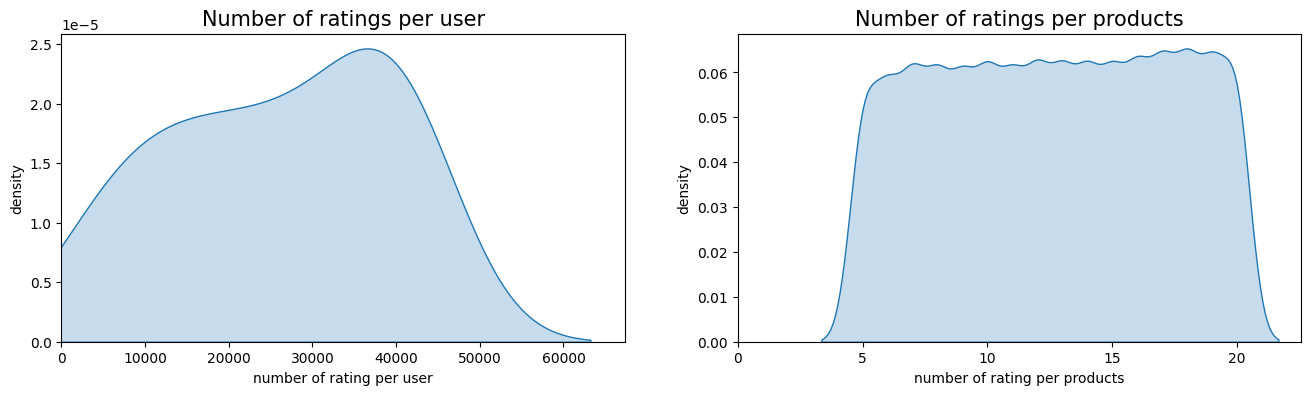

In [54]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, fill=True)
plt.xlim(0)
plt.title("Number of ratings per user", fontsize=15)
plt.xlabel("number of rating per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_products, fill=True)
plt.xlim(0)
plt.title("Number of ratings per products", fontsize=15)
plt.xlabel("number of rating per products")
plt.ylabel("density")
plt.show()


### Item-Item Recommendation System

In [55]:
def get_similar_product(product_id, X, product_mapper, product_mapper_inv, k, metric="cosine"):

    """
    Finds k-nearest neighbours for a given product id.

    Args:
        product_id: id of the product of interest
        X: user-item utility matrix
        k: number of similar product to retrieve
        metric: distance metric for kNN calculations

    Output: returns list of k similar product ID's
    """

    X = X.T
    neighbours_id = []

    product_ind = product_mapper[product_id]
    product_vec = X[product_ind]

    if isinstance(product_vec, (np.ndarray)):
        product_vec = product_vec.reshape(1,-1)

    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(product_vec, return_distance=False)
    for i in range(0, k):
        n = neighbour.item(i)
        neighbours_id.append(product_mapper_inv[n])
    neighbours_id.pop(0)
    return neighbours_id

In [56]:
similar_product = get_similar_product(1, X, product_mapper=product_mapper, product_mapper_inv=product_mapper_inv, k=5)

In [57]:
similar_product

[9233, 30648, 13915, 28404]

In [58]:
products_name = dict(zip(updated_products['productId'], updated_products['name']))
product_id = 10

similar_product = get_similar_product(product_id=product_id, X=X, product_mapper=product_mapper, product_mapper_inv=product_mapper_inv, k=5)
product_name = products_name[product_id]

print(f"Because you like {product_name}:\n ")
for i in similar_product:
    print(products_name[i])


Because you like SAFARI 15 Ltrs Sea Blue Casual/School/College Backpack (DAYPACKNEO15CBSEB):
 
FORSSIL Present Present Buckled Velvet Formal Casual Slip-on Loafers Shoes for Men and Boys (FSL-0521)
Tygot 10 Inches Big LED Ring Light for Camera, Phone tiktok YouTube Video Shooting and Makeup, 10" inch Ring Light with 7 ...
SG Musical Best QualityMart Bamboo Flute G Scale
Jockey Men's Cotton Undershirt (Pack of 3) White


#### Content-Based Filtering
- based on ```main_category``` column

In [59]:
main_categories = set(s for s in updated_products['main_category'])

In [60]:
# Create dataframe for products name and id
product_name_df = pd.DataFrame(updated_products['name'].unique(), columns=['name'])
product_id_df = pd.DataFrame(updated_products['productId'].unique(), columns=['productId'])

In [61]:
product_id_df.shape, product_name_df.shape

((41200, 1), (41200, 1))

In [62]:
# Join product_id and product_name to create new dataframe product_df
products_df = pd.concat([product_id_df['productId'], product_name_df['name']], axis=1, keys=['productId', 'name'])
products_df.head()

,productId,name
0,1,GLUN Bolt Electronic Portable Fishing Hook Typ...
1,2,Boldfit Shoe Bag for Travel & Storage Travel O...
2,3,Storite 2 Pack Moisture Proof Nylon Large Size...
3,4,GoTrippin Metal Luggage Weighing Scale Digital...
4,5,"Safari Pentagon Trolley Bags for Travel, 55 cm..."


In [63]:
products_df = products_df.join(updated_products['main_category'],on='productId')
products_df

,productId,name,main_category
0,1,GLUN Bolt Electronic Portable Fishing Hook Typ...,accessories
1,2,Boldfit Shoe Bag for Travel & Storage Travel O...,accessories
2,3,Storite 2 Pack Moisture Proof Nylon Large Size...,accessories
3,4,GoTrippin Metal Luggage Weighing Scale Digital...,accessories
4,5,"Safari Pentagon Trolley Bags for Travel, 55 cm...",accessories
...,...,...,...
41195,41196,Metro Women Beaded Sandals (35-3787),appliances
41196,41197,Sharon by Khadim's Women Grey Heel Sandal,appliances
41197,41198,Denill Women And Girls Ankle Strap Fashion San...,appliances
41198,41199,RESTAYEL Woman Trending Stylish Fancy and Comf...,appliances


In [64]:
for sc in main_categories:
    products_df[sc] = products_df.main_category.transform(lambda x: int(sc in x))

In [65]:
products_df.head(3)

,productId,name,main_category,beauty & health,bags & luggage,accessories,men's clothing,appliances,toys & baby products,women's clothing,...,women's shoes,men's shoes,grocery & gourmet foods,car & motorbike,kids' fashion,"tv, audio & cameras",music,home & kitchen,"home, kitchen, pets",industrial supplies
0,1,GLUN Bolt Electronic Portable Fishing Hook Typ...,accessories,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Boldfit Shoe Bag for Travel & Storage Travel O...,accessories,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Storite 2 Pack Moisture Proof Nylon Large Size...,accessories,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
products_category = products_df.drop(columns=['productId', 'name', 'main_category'])

In [67]:
cosine_sim = cosine_similarity(products_category, products_category)
print(f"Dimensions of our main category cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our main category cosine similarity matrix: (41200, 41200)


In [68]:
cosine_sim[0]

array([1., 1., 1., ..., 0., 0., 0.])

In [69]:
def product_finder(name):
    all_product_name = products_df['name'].tolist()
    closest_match = process.extractOne(name, all_product_name)
    return closest_match[0]

In [70]:
product_idx = dict(zip(products_df['name'], list(products_df.index)))

In [71]:
product_finder("Shoe bag")

'Bag'

In [72]:
def get_content_based_recommendations(title_string, n_recommendations=5):
    name = product_finder(title_string)
    print(name)
    idx = product_idx[name]
    sim_scores = list(enumerate(cosine_sim[idx]))
    # print(sim_scores)
    sim_scores = sorted(sim_scores, key=lambda x:x[1], reverse=True)
    # print(sim_scores)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_products = [i[0] for i in sim_scores]
    print(similar_products)
    print(f"Because you like product, {name}:")
    print(products_df['name'].iloc[similar_products])

In [73]:
get_content_based_recommendations("Bags with trolleys")

Bag
[1, 2, 3, 4, 5]
Because you like product, Bag:
1    Boldfit Shoe Bag for Travel & Storage Travel O...
2    Storite 2 Pack Moisture Proof Nylon Large Size...
3    GoTrippin Metal Luggage Weighing Scale Digital...
4    Safari Pentagon Trolley Bags for Travel, 55 cm...
5    WildHorn Brown RFID Blocking Leather Wallet fo...
Name: name, dtype: object
